In [5]:
from qiskit import IBMQ, pulse, schedule
from qiskit.circuit import QuantumCircuit, Gate, Parameter
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram
from sympy import *
from sympy.physics.quantum import *

import numpy as np
from numpy import loadtxt
import pandas as pd

import warnings

warnings.filterwarnings('ignore')

In [6]:
IBMQ.load_account()  # load if no backend satisfies
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibm_oslo')
qubit = 0
backend_config = backend.configuration()
dt = backend_config.dt
backend_defaults = backend.defaults()

ibmqfactory.load_account:WARNING:2022-08-26 19:38:44,434: Credentials are already in use. The existing account in the session will be replaced.


In [7]:
f01 = 4925170000.0
f12 = 4581552617.648945

d12_duration = 544
d12_amplitude = 0.10879003883868105
d12_sigma = 40

d01_duration = 544
d01_sigma = 67
d01_amplitude = 0.07999888439750123

# Discriminator

In [50]:
scale_factor = 1e-7

def get_job_data(job, average):
    """Retrieve data from a job that has already run.
    Args:
        job (Job): The job whose data you want.
        average (bool): If True, gets the data assuming data is an average.
                        If False, gets the data assuming it is for single shots.
    Return:
        list: List containing job result data.
    """
    job_results = job.result(timeout = 120) # timeout parameter set to 120 s
    result_data = []
    for i in range(len(job_results.results)):
        if average: # get avg data
            result_data.append(np.real(job_results.get_memory(i)[qubit] * scale_factor))
        else: # get single data
            result_data.append(job_results.get_memory(i)[:, qubit] * scale_factor)
    return result_data

def get_closest_multiple_of_16(num):
    """Compute the nearest multiple of 16. Needed because pulse enabled devices require
    durations which are multiples of 16 samples.
    """
    return int(num + 8 ) - (int(num + 8 ) % 16)

In [54]:
# load array
filename = 'discr_data.csv'
data = pd.read_csv(filename, sep=",", header=None)
data = data.applymap(lambda s: np.complex(s.replace('i', 'j'))).values
zero_data = data[0]
one_data = data[1]
two_data = data[2]

def reshape_complex_vec(vec):
    """Take in complex vector vec and return 2d array w/ real, imag entries. This is needed for the learning.
    Args:
        vec (list): complex vector of data
    Returns:
        list: vector w/ entries given by (real(vec], imag(vec))
    """
    length = len(vec)
    vec_reshaped = np.zeros((length, 2))
    for i in range(len(vec)):
        vec_reshaped[i] = [np.real(vec[i]), np.imag(vec[i])]
    return vec_reshaped

# Create IQ vector (split real, imag parts)
zero_data_reshaped = reshape_complex_vec(zero_data)
one_data_reshaped = reshape_complex_vec(one_data)
two_data_reshaped = reshape_complex_vec(two_data)

IQ_012_data = np.concatenate((zero_data_reshaped, one_data_reshaped, two_data_reshaped))
print(IQ_012_data.shape)  # verify IQ data shape

NUM_SHOTS = 20000

from sklearn.model_selection import train_test_split

# construct vector w/ 0's, 1's and 2's (for testing)
state_012 = np.zeros(NUM_SHOTS)  # shots gives number of experiments
state_012 = np.concatenate((state_012, np.ones(NUM_SHOTS)))
state_012 = np.concatenate((state_012, 2 * np.ones(NUM_SHOTS)))
print(len(state_012))

# Shuffle and split data into training and test sets
IQ_012_train, IQ_012_test, state_012_train, state_012_test = train_test_split(IQ_012_data, state_012, test_size=0.5)

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Set up the LDA
LDA_012 = LinearDiscriminantAnalysis()
LDA_012.fit(IQ_012_train, state_012_train)

def count(job, discriminator):
    data = get_job_data(job, average=False)
    sched_data = []
    for i in range(len(data)):
        sched_data.append(reshape_complex_vec(data[i]))
    discrim_data = []
    for j in range(len(sched_data)):
        discrim_data.append(discriminator.predict(sched_data[i]))
    final_result = []
    for k in range(len(discrim_data)):
        result = {'0': 0, '1': 0, '2': 0}
        for l in range(len(discrim_data[k])):
            if discrim_data[k][l] == 0.0:
                result['0'] += 1
            elif discrim_data[k][l] == 1.0:
                result['1'] += 1
            elif discrim_data[k][l] == 2.0:
                result['2'] += 1
            else:
                print('Unexpected behavior')
        final_result.append(result)
    return final_result

(60000, 2)
60000


In [ ]:
import matplotlib.pyplot as plt
def IQ_012_plot(x_min, x_max, y_min, y_max):
    """Helper function for plotting IQ plane for 0, 1, 2. Limits of plot given
    as arguments."""
    # zero data plotted in blue
    plt.scatter(np.real(zero_data), np.imag(zero_data),
                s=5, cmap='viridis', c='blue', alpha=0.5, label=r'$|0\rangle$')
    # one data plotted in red
    plt.scatter(np.real(one_data), np.imag(one_data),
                s=5, cmap='viridis', c='red', alpha=0.5, label=r'$|1\rangle$')
    # two data plotted in green
    plt.scatter(np.real(two_data), np.imag(two_data),
                s=5, cmap='viridis', c='green', alpha=0.5, label=r'$|2\rangle$')

    # Plot a large dot for the average result of the 0, 1 and 2 states.
    mean_zero = np.mean(zero_data) # takes mean of both real and imaginary parts
    mean_one = np.mean(one_data)
    mean_two = np.mean(two_data)
    plt.scatter(np.real(mean_zero), np.imag(mean_zero),
                s=200, cmap='viridis', c='black',alpha=1.0)
    plt.scatter(np.real(mean_one), np.imag(mean_one),
                s=200, cmap='viridis', c='black',alpha=1.0)
    plt.scatter(np.real(mean_two), np.imag(mean_two),
                s=200, cmap='viridis', c='black',alpha=1.0)

    plt.xlim(x_min, x_max)
    plt.ylim(y_min,y_max)
    plt.legend()
    plt.ylabel('I [a.u.]', fontsize=15)
    plt.xlabel('Q [a.u.]', fontsize=15)
    plt.title("0-1-2 discrimination", fontsize=15)

In [10]:
clifford_parameter = loadtxt('clifford_parameter.csv', delimiter=',')

# $X_\pi^{(01)}$ and  $X_\pi^{(12)}$ instructions

In [11]:
def X01_sched(theta):
    return pulse.play(pulse.Gaussian(duration = d01_duration,
                                     amp = (theta / np.pi) * d01_amplitude,
                                     sigma = d01_sigma), drive_chan)
def X12_sched(theta):
    return pulse.play(pulse.Gaussian(duration=d12_duration,
                                     amp=(theta / np.pi) * d12_amplitude,
                                     sigma=d12_sigma), drive_chan)

# Hadamard pulse instruction

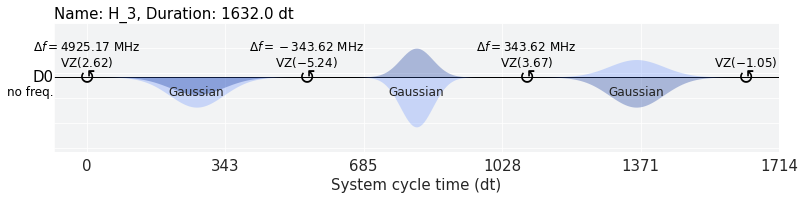

In [18]:
theta_1, theta_2, theta_3, phi_1, phi_2, phi_3, phi_4, phi_5, phi_6 = clifford_parameter[0]

phase01 = 0
phase12 = 0
with pulse.build(backend=backend, default_alignment='sequential', name=r'H_3') as Hadamard1:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(f01, drive_chan)
    with pulse.phase_offset(phase01 + phi_1, drive_chan):
        X01_sched(theta_1)
    pulse.set_frequency(f12, drive_chan)
    with pulse.phase_offset(phase12 - phi_2, drive_chan):
        X12_sched(theta_2)
    pulse.set_frequency(f01, drive_chan)
    with pulse.phase_offset(phase01 + phi_3, drive_chan):
        X01_sched(theta_3)
Hadamard1.draw()

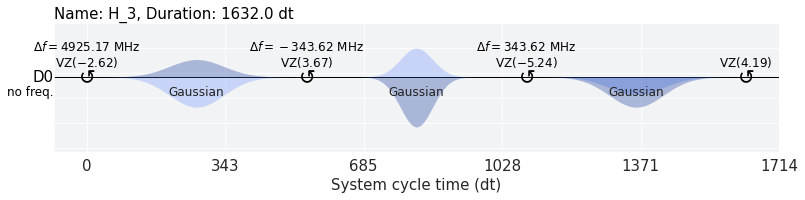

In [19]:
phase01 += phi_4 - phi_5
phase12 += phi_6 - phi_5

with pulse.build(backend=backend, default_alignment='sequential', name=r'H_3') as Hadamard2:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(f01, drive_chan)
    with pulse.phase_offset(phase01 + phi_1, drive_chan):
        X01_sched(theta_1)
    pulse.set_frequency(f12, drive_chan)
    with pulse.phase_offset(phase12 - phi_2, drive_chan):
        X12_sched(theta_2)
    pulse.set_frequency(f01, drive_chan)
    with pulse.phase_offset(phase01 + phi_3, drive_chan):
        X01_sched(theta_3)
Hadamard2.draw()

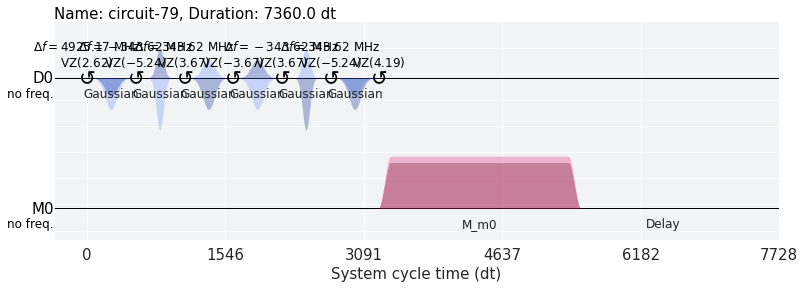

In [20]:
qc = QuantumCircuit(1,1)

H1 = Gate('Hadamard 1', 1, [])
H2 = Gate('Hadamard 2', 1, [])

qc.append(H1, [0])
qc.append(H2, [0])
qc.measure(0,0)
qc.add_calibration(H1, (0,), Hadamard1, [])
qc.add_calibration(H2, (0,), Hadamard2, [])

sched = schedule(qc, backend)
sched.draw()

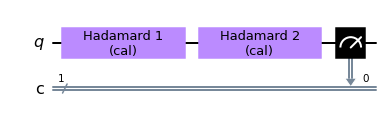

In [21]:
qc.draw(output = 'mpl')

In [55]:
num_shots = 2**13

job = backend.run(qc,
                  meas_level=1,
                  meas_return='single',
                  shots=num_shots)

job_monitor(job)

Job Status: job has successfully run


In [56]:
# job = backend.retrieve_job('6308e155a7ff8377907835b3')

In [58]:
print(job.job_id())

6308e155a7ff8377907835b3


In [62]:
job = backend.retrieve_job('6309a4d9dce5361952a40875')

In [63]:
count(job, LDA_012)

[{'0': 172, '1': 843, '2': 18985},
 {'0': 172, '1': 843, '2': 18985},
 {'0': 172, '1': 843, '2': 18985}]

In [ ]:
def count(job, discriminator):
    data = get_job_data(job, average=False)
    sched_data = []
    for i in range(len(data)):
        sched_data.append(reshape_complex_vec(data[i]))
    discrim_data = []
    for j in range(len(sched_data)):
        discrim_data.append(discriminator.predict(sched_data[i]))
    final_result = []
    for k in range(len(discrim_data)):
        result = {'0': 0, '1': 0, '2': 0}
        for l in range(len(discrim_data[k])):
            if discrim_data[k][l] == 0.0:
                result['0'] += 1
            elif discrim_data[k][l] == 1.0:
                result['1'] += 1
            elif discrim_data[k][l] == 2.0:
                result['2'] += 1
            else:
                print('Unexpected behavior')
        final_result.append(result)
    return final_result

In [65]:
data = get_job_data(job, average=False)

In [66]:
data

[array([-4.9696124-16.8582144j, -9.8640808-16.2599216j,
        -3.503358 -14.2564432j, ..., -6.5250648-14.0338112j,
        -5.1851732-15.8489968j, -5.6860476-10.2257032j]),
 array([15.0211616-18.7309312j, 18.554056 -16.3498832j,
        21.9150992-19.3348176j, ..., 19.4598864-21.685888j ,
        17.2298304-17.6915072j, 17.6324208-15.9829152j]),
 array([13.0435656-2.4047564j, 16.7372624+0.3915894j,
        15.243344 -2.5987832j, ..., 16.2633632+5.2120292j,
        13.841232 -0.8670573j,  9.9331312-2.955574j ])]